# Introduction

My friend [Andrew Key] and I are developing a series of [Data Science Challenges] to help each other and others become better Data Scientists by working on hands-on projects.

This notebook contains my work for the first challenge, _Exploring the Meetup API_ in my city of choice, beautiful **Vancouver, BC**.

## Challenge 01: Explore the Meetup API

Use the [Meetup API] to explore meetups in your city of choice.

**Guide Questions:**

Below are some guide line questions to get you started:

- What is the largest meetup in your location of choice (city, cities, country...etc)?
- How many meetups of a certain category (e.g. Tech, Art...etc) are in your city?
- Basic statistics of meetups
    - What is the average size of meetups?
    - How frequently do meetups host events?

## My guideline

I will focus on exploring the Tech Meetups in Vancouver. Specifically, I will look at the size and activity of these meetups.

As I explore the data, I will also raise additional questions that could be further explored as extensions to this project.

[//]: # (References)
[Andrew Key]: https://github.com/redpanda-ai
[Data Science Challenges]: https://johannesgiorgis.com/introducing-data-science-challenges/
[Meetup API]: https://www.meetup.com/meetup_api/

In [1]:
# import libraries

import datetime
import math
import meetup.api
import os
import pprint
import requests

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from mpl_toolkits.basemap import Basemap
from pandas.plotting import scatter_matrix

%matplotlib inline

Make sure you have set up **MEETUP_API_KEY** in your environment:

In _Ubuntu_:

1. Open `/etc/environment` as super user - e.g. `sudo vim /etc/environment`
2. Add `MEETUP_API_KEY="YOUR MEETUP API KEY"`
3. Open a new terminal and verify: `env | grep -i meetup`

In _MacOS_:

1. Open `~/.bash_profile`
2. Add `export MEETUP_API_KEY="YOUR MEETUP API KEY"` at the end of the file
3. Open a new terminal and verify: `env | grep -i meetup`

In [2]:
assert 'MEETUP_API_KEY' in os.environ, (
    "You need MEETUP_API_KEY in your environment"
)
client = meetup.api.Client()

---

## Helper Functions

Let's first create some helper functions.

I got the `parse_response` function from my friend Andy. Below are the explanations from his [notebook]:

This helper function helps us parse out the two most useful different pieces:

1. **meta**: an object containing meta-data about the response object itself
2. **results**: A page of actual data from the entire result of our API call



[notebook]: https://github.com/redpanda-ai/datascience_challenges/blob/master/01_explore_meetup_api/explore_sf_meetups.ipynb

In [3]:
def parse_response(response):
    '''returns two dataframes, meta and results:
        - meta: a vertically aligned dataframe, where each row is an element
            of the response.meta dictionary
        - results: a horizontally aligned dataframe, where each column is
            an element of the response.results dictionary'''
    meta = pd.DataFrame.from_dict(response.meta, orient='index')
    results = pd.DataFrame.from_dict(response.results)
    return (meta, results)

---

## Get Groups

We are interested in exploring Tech Meetup groups based in _Vancouver, BC_. We will use the [GetGroups] method to get the information we need.

The method requires the following information:

- Category ID
- Location information: _country/state/city, latitude+longitude, or zip code_

**Category ID**

We don't know what Category ID to use. We will have to find this via the [GetCategories] method.


**Location Information**

We know the city, province and country that we are interested in. The following parameters are what we need to provide in the `GetGroups` method to specify a location:

- **city** – A valid country code, city and for the US, State.
- **country** – A valid country code, city and for the US, State.
- **lat** – A valid latitude and longitude
- **lon** – A valid latitude and longitude
- **zip** – A valid US zip code

These 5 parameters limit the returned groups to within a 6th parameter, **radius** miles of the specified location.

- **radius** – Radius, in miles for geographic requests, default 25 – maximum 100

Let's use the _city_ and _country_ parameters, but we are not sure what the API considers a **valid country code**. We can use the [GetCities] method to get this information.

[GetGroups]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html?highlight=getgroups#meetup.api.meetup.api.Client.GetGroups
[GetCategories]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html#meetup.api.meetup.api.Client.GetCategories
[GetCities]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html?highlight=getgroups#meetup.api.meetup.api.Client.GetCities

### Categories

Let's use the [GetCategories] method to discover the different categories and their IDs:

[GetCategories]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html#meetup.api.meetup.api.Client.GetCategories

In [4]:
categories_resp = client.GetCategories()

29/30 (10 seconds remaining)


In [5]:
categories_meta_df, categories_df = parse_response(categories_resp)

In [6]:
categories_meta_df

,0
next,
method,Categories
total_count,33
link,https://api.meetup.com/2/categories
count,33
description,Returns a list of Meetup group categories
lon,None
title,Categories
url,https://api.meetup.com/2/categories?offset=0&f...
id,


We observe there are 33 Meetup categories.

#### How the Meetup API works¶

Let's use this opportunity to understand the Meetup API by looking at the `next` field in the metadata.

Meetup API v2 response payloads are returned in pages, one at a time. Each page by default returns 200 records. If there is more than 1 page of results, the metadata will provide the URI for the next API call in the sequence via the `next` field. We can take advantage of this to programmatically get each subsequent page until we have collected all of the records we are looking for.

In the above metadata, since there are only 33 categories (`total_count` is 33), they are all returned in the first page. Therefore, the `next` field is empty as there is no need for any subsequent API calls to get more records.

In [7]:
categories_df

,id,name,shortname,sort_name
0,1,Arts & Culture,Arts,Arts & Culture
1,18,Book Clubs,Book Clubs,Book Clubs
2,2,Career & Business,Business,Career & Business
3,3,Cars & Motorcycles,Auto,Cars & Motorcycles
4,4,Community & Environment,Community,Community & Environment
5,5,Dancing,Dancing,Dancing
6,6,Education & Learning,Education,Education & Learning
7,8,Fashion & Beauty,Fashion,Fashion & Beauty
8,9,Fitness,Fitness,Fitness
9,10,Food & Drink,Food & Drink,Food & Drink


We see the 33 category records, where each category record has an ID, name, short name and a sort name.

**Tech's category id is _34_. We will use this.**

### Get Cities

Let's use the [GetCities] method to figure out what the API considers a **valid country code**. Let's use 'Canada' as the country, representing the country code and 'Vancouver' as the query, representing the search term.

[GetGroups]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html?highlight=getgroups#meetup.api.meetup.api.Client.GetGroups
[GetCities]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html?highlight=getgroups#meetup.api.meetup.api.Client.GetCities

In [8]:
cities_resp = client.GetCities(country='Canada', query='Vancouver')

28/30 (10 seconds remaining)


In [9]:
cities_meta_df, cities_df = parse_response(cities_resp)

In [10]:
cities_meta_df

,0
next,
method,Cities
total_count,2
link,https://api.meetup.com/2/cities
count,2
description,Returns Meetup cities. This method supports se...
lon,None
title,Cities
url,https://api.meetup.com/2/cities?offset=0&query...
id,


In [11]:
cities_df

,city,country,id,lat,localized_country_name,lon,member_count,name_string,ranking,state,zip
0,Vancouver,ca,857064,49.279999,Canada,-123.040001,39959,"Vancouver, British Columbia, Canada",0,BC,V5K 0A1
1,Vancouver,us,98660,45.639999,USA,-122.680000,4699,"Vancouver, Washington, USA",1,WA,98660


**Observation**:

Our query returned 2 Vancouvers - one based in Canada and another in the USA. So the country code used (`Canada`) was **not valid**. 

But from our results, we can see the correct country code is **ca**. Let's confirm this.

In [12]:
cities_resp = client.GetCities(country='ca', query='Vancouver')
cities_meta_df, cities_df = parse_response(cities_resp)
cities_df

27/30 (10 seconds remaining)


,city,country,id,lat,localized_country_name,lon,member_count,name_string,ranking,state,zip
0,Vancouver,ca,857064,49.279999,Canada,-123.040001,39959,"Vancouver, British Columbia, Canada",0,BC,V5K 0A1


Now we have found the correct **country code (`ca`)** and confirmed we are getting the one city that interests us.

---

## Get Tech Meetup Groups

We now have the necessary information to use the `GetGroups` method to get Tech Meetup groups based in Vancouver, BC:

- **category_id**: 34
- **city**: Vancouver
- **country**: ca
 

In [13]:
# searching for Vancouver, Canada tech groups
groups_resp = client.GetGroups(category_id=34, city='Vancouver', country='ca')
groups_meta_df, groups_df = parse_response(groups_resp)
groups_meta_df

26/30 (10 seconds remaining)


,0
next,https://api.meetup.com/2/groups?country=ca&off...
method,Groups
total_count,434
link,https://api.meetup.com/2/groups
count,200
description,None
lon,-123.04
title,Meetup Groups v2
url,https://api.meetup.com/2/groups?country=ca&off...
id,


**Observations**

From the response's metadata, we observe that there are **433** Tech Meetup groups in Vancouver, BC. Per the earlier explanation about how the Meetup API sends back **pages** of results, we only received a single page of **200** group records.

Let's build a function to collect all of the group records spanning multiple pages and return them as a single Dataframe. This function was adapted from my friend Andy's [notebook]:


[notebook]: https://github.com/redpanda-ai/datascience_challenges/blob/master/01_explore_meetup_api/explore_sf_meetups.ipynb

In [14]:
def get_all_groups_as_df(category_id=34, city='Vancouver', country='ca', radius=25):
    '''returns all groups as a dataframe'''
    
    groups_df_list = []
    page_number = 0
    next_page = None
    
    while next_page != '':
        groups_resp = client.GetGroups(
            category_id=category_id,
            city=city, 
            country=country,
            offset=page_number,
            radius=radius
        )
        next_page = groups_resp.meta['next']
        _, group_df = parse_response(groups_resp)
        
        groups_df_list.append(group_df)
        page_number += 1
    
    return pd.concat(groups_df_list, ignore_index=True)

In [15]:
groups_df = get_all_groups_as_df()
groups_df.shape

25/30 (8 seconds remaining)
24/30 (7 seconds remaining)
23/30 (6 seconds remaining)


(434, 22)

We successfully got all 433 Tech Meetup groups by checking the size of our dataframe against the `total_count` from the response's metadata.

Time to explore :)

#### Side Bar

As a side bar, let's look at an example of a group in its raw JSON format. The `pprint.pprint()` function is a great way of showing JSON data / Python Dictionaries:

In [16]:
pprint.pprint(groups_resp.results[0])

{'category': {'id': 34, 'name': 'tech', 'shortname': 'tech'},
 'city': 'Vancouver',
 'country': 'CA',
 'created': 1034097731000,
 'description': '<p><span>The Vancouver Blogger Meetup Group is a platform '
                'where blogger and social media professionals and enthusiasts '
                'interact and network. This platform aims to be a reference '
                'and provide valuable information to graduates, professionals, '
                'small and medium sized businesses.&nbsp;<br><br>We are '
                'currently working on revitalizing this MeetUp Group and will '
                'soon bring up some topics for Meetups. Please, join our group '
                'and feel free to contact us at any time. Stay '
                'tuned!&nbsp;<br><br>Thank you and enjoy!</span></p>',
 'group_photo': {'base_url': 'https://secure.meetupstatic.com',
                 'highres_link': 'https://secure.meetupstatic.com/photos/event/2/4/f/f/highres_438549471.jpeg',
        

## Explore Tech Groups

Let's explore our dataframe.

In [17]:
groups_df.columns

Index(['category', 'city', 'country', 'created', 'description', 'group_photo',
       'id', 'join_mode', 'lat', 'link', 'lon', 'members', 'name', 'organizer',
       'rating', 'state', 'timezone', 'topics', 'urlname', 'utc_offset',
       'visibility', 'who'],
      dtype='object')

In [18]:
groups_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 22 columns):
category       434 non-null object
city           434 non-null object
country        434 non-null object
created        434 non-null int64
description    434 non-null object
group_photo    237 non-null object
id             434 non-null int64
join_mode      434 non-null object
lat            434 non-null float64
link           434 non-null object
lon            434 non-null float64
members        434 non-null int64
name           434 non-null object
organizer      431 non-null object
rating         434 non-null float64
state          434 non-null object
timezone       434 non-null object
topics         434 non-null object
urlname        434 non-null object
utc_offset     434 non-null int64
visibility     434 non-null object
who            434 non-null object
dtypes: float64(3), int64(4), object(15)
memory usage: 74.7+ KB


In [19]:
groups_df.head(5)

,category,city,country,created,description,group_photo,id,join_mode,lat,link,...,name,organizer,rating,state,timezone,topics,urlname,utc_offset,visibility,who
0,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,CA,1034097731000,<p><span>The Vancouver Blogger Meetup Group is...,{'highres_link': 'https://secure.meetupstatic....,21636,approval,49.279999,https://www.meetup.com/The-Vancouver-Blogger-M...,...,The Vancouver Blogger Meetup Group,"{'member_id': 66805072, 'name': 'Fabiano Macie...",4.32,BC,Canada/Pacific,"[{'urlkey': 'smallbiz', 'name': 'Small Busines...",The-Vancouver-Blogger-Meetup-Group,-28800000,public,Friends
1,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,CA,1036650741000,"<p>Hello Everyone,</p>\n<p>My name is Nathan a...",NaN,71383,open,49.279999,https://www.meetup.com/My-Internet-Media-Groups/,...,My Internet Media Groups,"{'member_id': 104036462, 'name': 'Nathan W.', ...",4.25,BC,Canada/Pacific,"[{'urlkey': 'photoshop', 'name': 'Photoshop', ...",My-Internet-Media-Groups,-28800000,public,Future Moguls
2,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,CA,1072723179000,<p>As the largest software development meetup ...,NaN,144695,open,49.279999,https://www.meetup.com/VanDev/,...,VanDev: Vancouver's Software Developers Network,"{'member_id': 273611362, 'name': 'Bevan Hunt',...",4.39,BC,Canada/Pacific,"[{'urlkey': 'softwaredev', 'name': 'Software D...",VanDev,-28800000,public,Software Developers
3,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,CA,1142734447000,<p>Vancouver Web Design is British Columbia's ...,{'highres_link': 'https://secure.meetupstatic....,229052,open,49.290001,https://www.meetup.com/webdesign-395/,...,The Vancouver Web Design Meetup Group,"{'member_id': 87486782, 'name': 'Darrell Hadde...",4.40,BC,Canada/Pacific,"[{'urlkey': 'webstandards', 'name': 'Web Stand...",webdesign-395,-28800000,public,Vancouver Web Design Meetup
4,"{'name': 'tech', 'id': 34, 'shortname': 'tech'}",Vancouver,CA,1184711936000,<p>Do you develop with Ruby? Make web applicat...,{'highres_link': 'https://secure.meetupstatic....,573925,open,49.279999,https://www.meetup.com/vancouver-ruby/,...,Vancouver Ruby Meetup Group,"{'member_id': 10374191, 'name': 'Philippe Creu...",4.59,BC,Canada/Pacific,"[{'urlkey': 'ruby', 'name': 'Ruby', 'id': 1040...",vancouver-ruby,-28800000,public,Ruby Developers


In [20]:
# explore the uniqueness of each column's values
def display_columns_unique_values(df):
    '''display each columns unique values
        - if only 1, will display it
        - if unable to get unique values, will display data structure type
    '''
    for column in df.columns:

        try:
            unique_values = df[column].unique()
            num_unique_values = len(unique_values)
            result = f"Column {column.upper():>15}: {num_unique_values:}"

            if num_unique_values == 1:
                result += f"|Unique values: {unique_values}"

            print(result)

        # some columns contain dict objects which aren't hashable so they are ignored
        except TypeError as tp:
            print(f"Column {column.upper()}: Type: {type(df[column][0])}")
            pass

In [21]:
display_columns_unique_values(groups_df)

Column CATEGORY: Type: <class 'dict'>
Column            CITY: 11
Column         COUNTRY: 1|Unique values: ['CA']
Column         CREATED: 434
Column     DESCRIPTION: 434
Column GROUP_PHOTO: Type: <class 'dict'>
Column              ID: 434
Column       JOIN_MODE: 2
Column             LAT: 22
Column            LINK: 434
Column             LON: 35
Column         MEMBERS: 343
Column            NAME: 434
Column ORGANIZER: Type: <class 'dict'>
Column          RATING: 67
Column           STATE: 1|Unique values: ['BC']
Column        TIMEZONE: 2
Column TOPICS: Type: <class 'list'>
Column         URLNAME: 434
Column      UTC_OFFSET: 1|Unique values: [-28800000]
Column      VISIBILITY: 3
Column             WHO: 193


In [22]:
groups_df['timezone'].unique()

array(['Canada/Pacific', 'America/Vancouver'], dtype=object)

In [23]:
groups_df['category'][0]

{'name': 'tech', 'id': 34, 'shortname': 'tech'}

**Observations**:

Our dataframe has 22 columns. We could drop a few columns.

A few columns contain only 1 unique value: `country` ('CA'), `state` ('BC') and `utc_offset` (representing UTC-8).

An additional column (`timezone`) only has 2 values (`['Canada/Pacific', 'America/Vancouver']`) which essentially represent the same information. 

The `category` column which contains dictionaries is also unnecessary as we are only looking at Tech meetups.

Let's go ahead and drop these columns.

In [24]:
columns_to_drop = ['country', 'state', 'utc_offset', 'timezone', 'category']
groups_df = groups_df.drop(columns=columns_to_drop)

In [25]:
groups_df.shape

(434, 17)

In [26]:
groups_df.columns

Index(['city', 'created', 'description', 'group_photo', 'id', 'join_mode',
       'lat', 'link', 'lon', 'members', 'name', 'organizer', 'rating',
       'topics', 'urlname', 'visibility', 'who'],
      dtype='object')

In [27]:
groups_df.head(5)

,city,created,description,group_photo,id,join_mode,lat,link,lon,members,name,organizer,rating,topics,urlname,visibility,who
0,Vancouver,1034097731000,<p><span>The Vancouver Blogger Meetup Group is...,{'highres_link': 'https://secure.meetupstatic....,21636,approval,49.279999,https://www.meetup.com/The-Vancouver-Blogger-M...,-123.129997,652,The Vancouver Blogger Meetup Group,"{'member_id': 66805072, 'name': 'Fabiano Macie...",4.32,"[{'urlkey': 'smallbiz', 'name': 'Small Busines...",The-Vancouver-Blogger-Meetup-Group,public,Friends
1,Vancouver,1036650741000,"<p>Hello Everyone,</p>\n<p>My name is Nathan a...",NaN,71383,open,49.279999,https://www.meetup.com/My-Internet-Media-Groups/,-123.120003,1866,My Internet Media Groups,"{'member_id': 104036462, 'name': 'Nathan W.', ...",4.25,"[{'urlkey': 'photoshop', 'name': 'Photoshop', ...",My-Internet-Media-Groups,public,Future Moguls
2,Vancouver,1072723179000,<p>As the largest software development meetup ...,NaN,144695,open,49.279999,https://www.meetup.com/VanDev/,-123.129997,6949,VanDev: Vancouver's Software Developers Network,"{'member_id': 273611362, 'name': 'Bevan Hunt',...",4.39,"[{'urlkey': 'softwaredev', 'name': 'Software D...",VanDev,public,Software Developers
3,Vancouver,1142734447000,<p>Vancouver Web Design is British Columbia's ...,{'highres_link': 'https://secure.meetupstatic....,229052,open,49.290001,https://www.meetup.com/webdesign-395/,-123.110001,4996,The Vancouver Web Design Meetup Group,"{'member_id': 87486782, 'name': 'Darrell Hadde...",4.40,"[{'urlkey': 'webstandards', 'name': 'Web Stand...",webdesign-395,public,Vancouver Web Design Meetup
4,Vancouver,1184711936000,<p>Do you develop with Ruby? Make web applicat...,{'highres_link': 'https://secure.meetupstatic....,573925,open,49.279999,https://www.meetup.com/vancouver-ruby/,-123.110001,2624,Vancouver Ruby Meetup Group,"{'member_id': 10374191, 'name': 'Philippe Creu...",4.59,"[{'urlkey': 'ruby', 'name': 'Ruby', 'id': 1040...",vancouver-ruby,public,Ruby Developers


In [28]:
display_columns_unique_values(groups_df)

Column            CITY: 11
Column         CREATED: 434
Column     DESCRIPTION: 434
Column GROUP_PHOTO: Type: <class 'dict'>
Column              ID: 434
Column       JOIN_MODE: 2
Column             LAT: 22
Column            LINK: 434
Column             LON: 35
Column         MEMBERS: 343
Column            NAME: 434
Column ORGANIZER: Type: <class 'dict'>
Column          RATING: 67
Column TOPICS: Type: <class 'list'>
Column         URLNAME: 434
Column      VISIBILITY: 3
Column             WHO: 193


**Observations**:

Now that we've done a little bit of clean up, let's look at the 17 remaining columns.

- `city`: It is interesting that there are 11 unique cities. We should look into this.
- Several columns match the size of our data so these columns contain values unique to each group
    - `created`
    - `description`
    - `id`
    - `link`
    - `name`
    - `urlname`
- 3 columns contain either lists or dictionaries. We'd have to do some more parsing if we are to explore these columns.
    - `group_photo`
    - `organier`
    - `topics`

- `lat` and `lon`: Short names for **latitude** and **longitude**. We could plot these on a map to see where groups tend to be based.
- `join_mode`: We could look into the different join modes and how many groups use one versus the other
- `members` & `ratings`: We could look into the distribution of members and ratings across the different groups
    - Do more highly rated meetup groups tend to have more members?
- `visibility`: We could see how visible groups tend to be
- `who`: We could see how many Tech Groups have the same or similar target group

Looking at a portion of our dataframe, the uniqueness, data ranges and tendencies of each column, and the raw JSON format of one group, helps us better understand our data and its structure. This leads us to better questions and areas of exploration. These observations and questions lead to additional project extension ideas.

### 11 Cities in 1 City?

We observed 11 unique values in the `city` column. I had expected only 1 city as we had specified '_Vancouver_' in our `GetGroups` method earlier.

Let's explore these:

In [29]:
groups_df['city'].unique()

array(['Vancouver', 'Langley', 'Surrey', 'North Vancouver', 'Burnaby',
       'Port Moody', 'New Westminster', 'Richmond', 'West Vancouver',
       'Port Coquitlam', 'Coquitlam'], dtype=object)

So meetups which are not strictly located in Vancouver are also returned. Looking more closely at the _city_ parameter for the `GetGroups` method:

- **city** – A valid country code, city and for the US, State. limits the returned groups to those within **radius miles**
- **radius** – Radius, in miles for geographic requests, default 25 – maximum 100

Aha! I forgot that the method returns Meetup groups within a **radius** of 25 miles of the specified location. So the 433 Tech Meetup groups we got are actually based within 25 miles of Vancouver, BC and spread across 11 cities.

Let's explore how many Tech meetups are based in each city:

In [30]:
groups_df.groupby(by='city').count()

,created,description,group_photo,id,join_mode,lat,link,lon,members,name,organizer,rating,topics,urlname,visibility,who
city,,,,,,,,,,,,,,,,
Burnaby,7,7,3,7,7,7,7,7,7,7,7,7,7,7,7,7
Coquitlam,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Langley,5,5,1,5,5,5,5,5,5,5,5,5,5,5,5,5
New Westminster,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1
North Vancouver,8,8,2,8,8,8,8,8,8,8,8,8,8,8,8,8
Port Coquitlam,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1
Port Moody,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2
Richmond,3,3,1,3,3,3,3,3,3,3,3,3,3,3,3,3
Surrey,9,9,5,9,9,9,9,9,9,9,9,9,9,9,9,9


Over **90%** of Tech Meetups are based in the city of Vancouver. Coming in second, Surrey has 9 Tech Meetups.

Before disregarding the non-Vancouver based Tech Meetups, let's check where the largest Tech Meetups by members are based:

In [31]:
groups_df.sort_values('members', ascending=False).head(20)

,city,created,description,group_photo,id,join_mode,lat,link,lon,members,name,organizer,rating,topics,urlname,visibility,who
172,Vancouver,1448718394000,<p>TechVancouver brings together Vancouver's t...,{'highres_link': 'https://secure.meetupstatic....,19162038,open,49.279999,https://www.meetup.com/TechVancouverOrg/,-123.040001,8797,TechVancouver,"{'member_id': 14219538, 'name': 'Alexander Nor...",4.78,"[{'urlkey': 'softwaredev', 'name': 'Software D...",TechVancouverOrg,public,Technologists
2,Vancouver,1072723179000,<p>As the largest software development meetup ...,NaN,144695,open,49.279999,https://www.meetup.com/VanDev/,-123.129997,6949,VanDev: Vancouver's Software Developers Network,"{'member_id': 273611362, 'name': 'Bevan Hunt',...",4.39,"[{'urlkey': 'softwaredev', 'name': 'Software D...",VanDev,public,Software Developers
60,Vancouver,1347316761000,<p><b>WHY ATTEND TECH SOCIALS?</b> Simple. To ...,{'highres_link': 'https://secure.meetupstatic....,4869742,open,49.279999,https://www.meetup.com/HackerNestVAN/,-123.120003,6715,HackerNest Vancouver Tech Socials,"{'member_id': 77652922, 'name': 'HackerNest', ...",4.75,"[{'urlkey': 'softwaredev', 'name': 'Software D...",HackerNestVAN,public,HackerNesters
98,Vancouver,1389135143000,<p><b>What is Cowork &amp; Coffee?</b></p>\n<p...,{'highres_link': 'https://secure.meetupstatic....,11908342,open,49.279999,https://www.meetup.com/codecoffeeyvr/,-123.139999,6299,Code & Coffee (Vancouver),"{'member_id': 8906905, 'name': 'Jenn Cooper', ...",4.65,"[{'urlkey': 'opensource', 'name': 'Open Source...",codecoffeeyvr,public,Developers
137,Vancouver,1422291923000,<p>Startup Founder 101 brings together aspirin...,{'highres_link': 'https://secure.meetupstatic....,18381330,open,49.279999,https://www.meetup.com/Vancouver-Startup-Found...,-123.040001,5772,Vancouver Startup Founder 101,"{'member_id': 11314237, 'name': 'Jonathan Gree...",4.58,"[{'urlkey': 'webdesign', 'name': 'Web Design',...",Vancouver-Startup-Founder-101,public,Aspiring Founders
16,Vancouver,1263596978000,<p>Meeting the right people is crucial. We loo...,{'highres_link': 'https://secure.meetupstatic....,1583286,open,49.279999,https://www.meetup.com/Vancouver-Tech-Co-Found...,-123.110001,5120,Vancouver Pixel Crafters,"{'member_id': 11767095, 'name': 'Hussein Halla...",4.62,"[{'urlkey': 'softwaredev', 'name': 'Software D...",Vancouver-Tech-Co-Founders,public,Entrepreneurs
3,Vancouver,1142734447000,<p>Vancouver Web Design is British Columbia's ...,{'highres_link': 'https://secure.meetupstatic....,229052,open,49.290001,https://www.meetup.com/webdesign-395/,-123.110001,4996,The Vancouver Web Design Meetup Group,"{'member_id': 87486782, 'name': 'Darrell Hadde...",4.40,"[{'urlkey': 'webstandards', 'name': 'Web Stand...",webdesign-395,public,Vancouver Web Design Meetup
23,Vancouver,1273291070000,<p>Vancouver is home to many game developers a...,{'highres_link': 'https://secure.meetupstatic....,1642334,open,49.270000,https://www.meetup.com/Vancouver-Indie-Game-De...,-123.120003,4829,Full Indie,"{'member_id': 2874080, 'name': 'Andrew Hamilto...",4.61,"[{'urlkey': 'gamedev', 'name': 'Game Developme...",Vancouver-Indie-Game-Developers,public,Indies
192,Vancouver,1462151582000,<p>We invite startup leaders and experts to sh...,{'highres_link': 'https://secure.meetupstatic....,19905099,open,49.259998,https://www.meetup.com/YVR-Startups/,-123.139999,4720,YVR Startups,"{'member_id': 41331852, 'name': 'Ed', 'photo':...",4.67,"[{'urlkey': 'webdesign', 'name': 'Web Design',...",YVR-Startups,public,Entrepreneurs
36,Vancouver,1300139469000,<p>This group is for anyone interested in uniq...,{'highres_link': 'https://secure.meetupstatic....,1798770,open,49.279999,https://www.meetup.com/Vancouver-Data-Visualiz...,-123.110001,3892,Vancouver Data Visualization,"{'member_id': 13904544, 'name': 'Wayne Carriga...",4.52,"[{'urlkey': 'opensource', 'name': 'Open Source...",Vancouver-Data-Visualization,public,Vizers


The top 20 largest Tech Meetups by number of members are all based in Vancouver. So we can drop the non-Vancouver based Tech Meetups without it affecting our original question of exploring group's number of members and activities.

In [32]:
vancouver_tech_groups = groups_df[groups_df['city'] == 'Vancouver']

In [33]:
vancouver_tech_groups.shape

(394, 17)

In [34]:
vancouver_tech_groups.head(5)

,city,created,description,group_photo,id,join_mode,lat,link,lon,members,name,organizer,rating,topics,urlname,visibility,who
0,Vancouver,1034097731000,<p><span>The Vancouver Blogger Meetup Group is...,{'highres_link': 'https://secure.meetupstatic....,21636,approval,49.279999,https://www.meetup.com/The-Vancouver-Blogger-M...,-123.129997,652,The Vancouver Blogger Meetup Group,"{'member_id': 66805072, 'name': 'Fabiano Macie...",4.32,"[{'urlkey': 'smallbiz', 'name': 'Small Busines...",The-Vancouver-Blogger-Meetup-Group,public,Friends
1,Vancouver,1036650741000,"<p>Hello Everyone,</p>\n<p>My name is Nathan a...",NaN,71383,open,49.279999,https://www.meetup.com/My-Internet-Media-Groups/,-123.120003,1866,My Internet Media Groups,"{'member_id': 104036462, 'name': 'Nathan W.', ...",4.25,"[{'urlkey': 'photoshop', 'name': 'Photoshop', ...",My-Internet-Media-Groups,public,Future Moguls
2,Vancouver,1072723179000,<p>As the largest software development meetup ...,NaN,144695,open,49.279999,https://www.meetup.com/VanDev/,-123.129997,6949,VanDev: Vancouver's Software Developers Network,"{'member_id': 273611362, 'name': 'Bevan Hunt',...",4.39,"[{'urlkey': 'softwaredev', 'name': 'Software D...",VanDev,public,Software Developers
3,Vancouver,1142734447000,<p>Vancouver Web Design is British Columbia's ...,{'highres_link': 'https://secure.meetupstatic....,229052,open,49.290001,https://www.meetup.com/webdesign-395/,-123.110001,4996,The Vancouver Web Design Meetup Group,"{'member_id': 87486782, 'name': 'Darrell Hadde...",4.40,"[{'urlkey': 'webstandards', 'name': 'Web Stand...",webdesign-395,public,Vancouver Web Design Meetup
4,Vancouver,1184711936000,<p>Do you develop with Ruby? Make web applicat...,{'highres_link': 'https://secure.meetupstatic....,573925,open,49.279999,https://www.meetup.com/vancouver-ruby/,-123.110001,2624,Vancouver Ruby Meetup Group,"{'member_id': 10374191, 'name': 'Philippe Creu...",4.59,"[{'urlkey': 'ruby', 'name': 'Ruby', 'id': 1040...",vancouver-ruby,public,Ruby Developers


In [35]:
display_columns_unique_values(vancouver_tech_groups)

Column            CITY: 1|Unique values: ['Vancouver']
Column         CREATED: 394
Column     DESCRIPTION: 394
Column GROUP_PHOTO: Type: <class 'dict'>
Column              ID: 394
Column       JOIN_MODE: 2
Column             LAT: 9
Column            LINK: 394
Column             LON: 20
Column         MEMBERS: 323
Column            NAME: 394
Column ORGANIZER: Type: <class 'dict'>
Column          RATING: 66
Column TOPICS: Type: <class 'list'>
Column         URLNAME: 394
Column      VISIBILITY: 3
Column             WHO: 184


In [36]:
# drop the city column
vancouver_tech_groups = vancouver_tech_groups.drop(columns=['city'])

Now that we have limited the groups to the city of Vancouver and further cleaned up our dataframe, let's limit the columns to the ones that interest us:

In [37]:
vancouver_tech_groups.columns

Index(['created', 'description', 'group_photo', 'id', 'join_mode', 'lat',
       'link', 'lon', 'members', 'name', 'organizer', 'rating', 'topics',
       'urlname', 'visibility', 'who'],
      dtype='object')

In [38]:
# columns to keep
keep_columns = ['id', 'name', 'members', 'rating', 'join_mode', 'visibility',
               'who', 'lat', 'lon']

vancouver_tech_groups = vancouver_tech_groups[keep_columns]

vancouver_tech_groups.head(5)

,id,name,members,rating,join_mode,visibility,who,lat,lon
0,21636,The Vancouver Blogger Meetup Group,652,4.32,approval,public,Friends,49.279999,-123.129997
1,71383,My Internet Media Groups,1866,4.25,open,public,Future Moguls,49.279999,-123.120003
2,144695,VanDev: Vancouver's Software Developers Network,6949,4.39,open,public,Software Developers,49.279999,-123.129997
3,229052,The Vancouver Web Design Meetup Group,4996,4.40,open,public,Vancouver Web Design Meetup,49.290001,-123.110001
4,573925,Vancouver Ruby Meetup Group,2624,4.59,open,public,Ruby Developers,49.279999,-123.110001


### Tech Meetup Members

Let's explore the distribution of members across Tech Meetups in Vancouver.

In [39]:
vancouver_tech_groups['members'].describe()

count     394.000000
mean      680.951777
std      1108.259677
min         1.000000
25%        86.000000
50%       295.000000
75%       699.250000
max      8797.000000
Name: members, dtype: float64

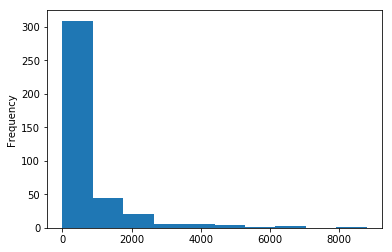

In [40]:
vancouver_tech_groups['members'].plot.hist()

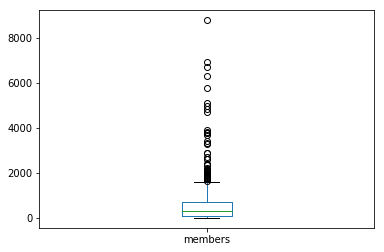

In [41]:
vancouver_tech_groups['members'].plot.box()

In [42]:
vancouver_tech_groups['members'].value_counts(bins = 10, normalize=True).sort_index(ascending=False) * 100

(7917.4, 8797.0]                0.253807
(7037.8, 7917.4]                0.000000
(6158.2, 7037.8]                0.761421
(5278.6, 6158.2]                0.253807
(4399.0, 5278.6]                1.015228
(3519.4, 4399.0]                1.269036
(2639.8, 3519.4]                1.522843
(1760.2, 2639.8]                5.329949
(880.6, 1760.2]                11.167513
(-7.797000000000001, 880.6]    78.426396
Name: members, dtype: float64

**Observations**:

From the descriptive statistics table that the `describe()` function provides us, we observe:

- average number of members is 681
- There is/are meetups with 1 member
- The largest meetup has 8778 members
- The median meetup member size is 295

Our histogram is a very rightly skewed plot, further demonstrating how most Tech Meetups have members in the 100's and not 1000's.

The box plot shows the large number of outliers. What is interesting is that there are a few clusters of outliers around the 2000 - 4000, another cluster around ~5000 and the rest spread out a bit more until we get to out largest group of 8778 members.

Lastly, the custom frequency table shows us that:

- almost **90%** of Tech Meetups have 1756 members or less, with a majority of these having less than 878
- Around **~9%** of Tech Meetups have between 1756 and 5267 members.

In [43]:
vancouver_tech_groups[vancouver_tech_groups['members'] == 1]

,id,name,members,rating,join_mode,visibility,who,lat,lon
433,31260167,Vancouver Amazon Seller Meetup AMZ One Step,1,0.0,open,public,Members,49.279999,-123.040001


In [44]:
vancouver_tech_groups[vancouver_tech_groups['id'] == 31231458]

,id,name,members,rating,join_mode,visibility,who,lat,lon
431,31231458,Vancouver Fintech Startups Meetup,5,0.0,approval,public,Members,49.279999,-123.040001


There is one Meetup with 1 member is the **Vancouver Lucene/Solr Meetup**. 

Members can only join the meetup by being approved, which may explain the low number of members if no one has been approved.

**NOTE**: When I first ran this on Sunday, February 24th 2019, there was only one Meetup with 1 member, the **Vancouver FinTech Startups Meetup**. When I ran this again on Monday, February 25th 2019, a different Meetup group had 1 member: **Vancouver Lucene/Solr Meetup**. The former Meetup now had 3 members. This may indicate some fluctuation in Meetup Groups as people are joining/leaving groups.

### Comparing Largest and Smallest Tech Meetups

Let's grab the largest and smallest Tech Meetup groups and compare them.

The largest and smallest groups are defined below:

- _Largest Groups_: Groups with members **larger than 10x the median number** of members.

- _Smallest Groups_: Groups with members **less than 1/10th of the median number** of members.

**Dealing with locations**

After some back and forth research done by plotting the largest and smallest Vancouver tech groups, we observed the challenges of dealing with two separate location values (`latitude` and `longitude`). A new column is created which combines both `latitutde` and `longitude` columns. This column will allow us to know exactly how many unique locations there really are.

In [45]:
vancouver_tech_groups['location'] = list(
    zip(vancouver_tech_groups['lat'], vancouver_tech_groups['lon'])
)

In [46]:
display_columns_unique_values(vancouver_tech_groups)

Column              ID: 394
Column            NAME: 394
Column         MEMBERS: 323
Column          RATING: 66
Column       JOIN_MODE: 2
Column      VISIBILITY: 3
Column             WHO: 184
Column             LAT: 9
Column             LON: 20
Column        LOCATION: 45


Now, we can tell that there are **45** unique locations for the **393** Tech Meetups in Vancouver.

**Additional Helper Functions**

In [47]:
def get_target_group_details(df):
    '''provides information on the target group'''
    unique_targets = df['who'].unique()

    print(f"There are {len(unique_targets)} unique targets: {unique_targets}\n")
    
    for target in unique_targets:
        unique_target = df[df['who'] == target]
        print(f"There are {unique_target.shape[0]} meetup(s) which target {target}")

#### Get the groups

In [48]:
median_members = vancouver_tech_groups['members'].median()
median_members

295.0

**Largest Tech Groups**

Let's grab the largest tech meetups:

In [49]:
largest_tech_groups = vancouver_tech_groups[vancouver_tech_groups['members'] > 10 * median_members]
print(largest_tech_groups.shape)
largest_tech_groups.sort_values('members', ascending=False)

(17, 10)


,id,name,members,rating,join_mode,visibility,who,lat,lon,location
172,19162038,TechVancouver,8797,4.78,open,public,Technologists,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"
2,144695,VanDev: Vancouver's Software Developers Network,6949,4.39,open,public,Software Developers,49.279999,-123.129997,"(49.279998779296875, -123.12999725341797)"
60,4869742,HackerNest Vancouver Tech Socials,6715,4.75,open,public,HackerNesters,49.279999,-123.120003,"(49.279998779296875, -123.12000274658203)"
98,11908342,Code & Coffee (Vancouver),6299,4.65,open,public,Developers,49.279999,-123.139999,"(49.279998779296875, -123.13999938964844)"
137,18381330,Vancouver Startup Founder 101,5772,4.58,open,public,Aspiring Founders,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"
16,1583286,Vancouver Pixel Crafters,5120,4.62,open,public,Entrepreneurs,49.279999,-123.110001,"(49.279998779296875, -123.11000061035156)"
3,229052,The Vancouver Web Design Meetup Group,4996,4.40,open,public,Vancouver Web Design Meetup,49.290001,-123.110001,"(49.290000915527344, -123.11000061035156)"
23,1642334,Full Indie,4829,4.61,open,public,Indies,49.270000,-123.120003,"(49.27000045776367, -123.12000274658203)"
192,19905099,YVR Startups,4720,4.67,open,public,Entrepreneurs,49.259998,-123.139999,"(49.2599983215332, -123.13999938964844)"
36,1798770,Vancouver Data Visualization,3892,4.52,open,public,Vizers,49.279999,-123.110001,"(49.279998779296875, -123.11000061035156)"


**Smallest Tech Groups**

Let's grab the smallest tech meetups:

In [50]:
smallest_tech_groups = vancouver_tech_groups[vancouver_tech_groups['members'] < (median_members/10)]
print(smallest_tech_groups.shape)
smallest_tech_groups.sort_values('members')

(30, 10)


,id,name,members,rating,join_mode,visibility,who,lat,lon,location
433,31260167,Vancouver Amazon Seller Meetup AMZ One Step,1,0.0,open,public,Members,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"
432,31252547,Vancouver Lucene/Solr Meetup,2,0.0,open,public,Members,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"
431,31231458,Vancouver Fintech Startups Meetup,5,0.0,approval,public,Members,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"
358,28804607,The Efficient Professional,7,0.0,approval,public,Members,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"
363,28978937,"ManageEngine IT Management Seminar, Vancouver",9,0.0,open,public_limited,Members,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"
349,28518984,Gastown Tech Meetup,9,0.0,approval,public,Members,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"
423,30948318,Algorand Vancouver: Blockchain Community,11,0.0,open,public,Members,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"
280,26300462,Vancouver MuleSoft Meetup Group,12,0.0,open,public,Members,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"
347,28458120,Vancouver MuleSoft User Group,12,0.0,open,public,Members,49.270000,-123.239998,"(49.27000045776367, -123.23999786376953)"
408,30478918,Vancouver Clojure & Lisp,13,0.0,approval,public,Parens,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"


#### Location of Largest and Smallest Tech Meet Ups

Let's look at where the largest and smallest Tech Meetups are located:

In [51]:
display_columns_unique_values(largest_tech_groups)

Column              ID: 17
Column            NAME: 17
Column         MEMBERS: 17
Column          RATING: 16
Column       JOIN_MODE: 1|Unique values: ['open']
Column      VISIBILITY: 1|Unique values: ['public']
Column             WHO: 15
Column             LAT: 4
Column             LON: 6
Column        LOCATION: 13


In [52]:
display_columns_unique_values(smallest_tech_groups)

Column              ID: 30
Column            NAME: 30
Column         MEMBERS: 19
Column          RATING: 1|Unique values: [0.]
Column       JOIN_MODE: 2
Column      VISIBILITY: 2
Column             WHO: 9
Column             LAT: 5
Column             LON: 5
Column        LOCATION: 5


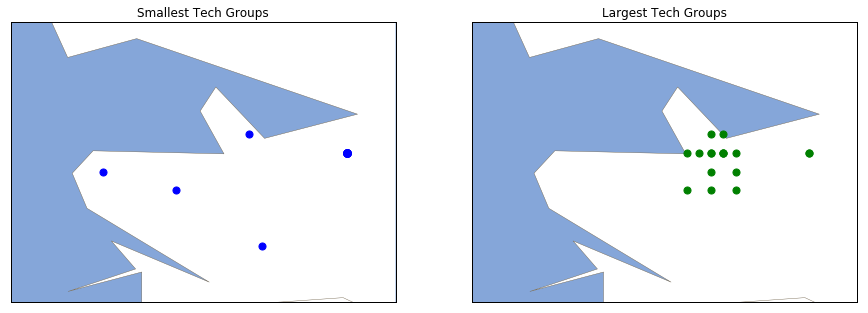

In [53]:
'''
projection: the map projection.
llcrnrlat: latitude of lower left hand corner of the desired map domain
urcrnrlat: latitude of upper right hand corner of the desired map domain
llcrnrlon: longitude of lower left hand corner of the desired map domain
urcrnrlon: longitude of upper right hand corner of the desired map domain
'''
lower_left_lat = 49.2
lower_left_lon = -123.316
upper_right_lat = 49.35
upper_right_lon = -123

fig = plt.figure(figsize=(40, 40))

groups = [smallest_tech_groups, largest_tech_groups]
colors = ['Blue', 'Green']
titles = ['Smallest Tech Groups', 'Largest Tech Groups']

for sp in range(0, 2):
    ax = fig.add_subplot(1, 5, sp+1)
    
    ax.set_title(titles[sp])
    
    m = Basemap(
        projection = 'merc',
        llcrnrlat = lower_left_lat,
        urcrnrlat = upper_right_lat,
        llcrnrlon = lower_left_lon,
        urcrnrlon = upper_right_lon,
        resolution = 'i',
    )

    m.drawmapboundary(fill_color='#85A6D9')
    m.drawcoastlines(color='#6D5F47', linewidth=.4)
    m.drawrivers(color='#6D5F47', linewidth=.4)
    m.fillcontinents(color='white',lake_color='#85A6D9')
    
    longitudes = groups[sp]['lon'].tolist()
    latitudes = groups[sp]['lat'].tolist()
    
    x, y = m(longitudes, latitudes)
    m.scatter(x, y, s=50, zorder=2, color=colors[sp], cmap='summer')

plt.show()

**Observation**:

From our map plots above, we observe that:

- the largest **17 Tech Meetups are spread across 13 locations**, but are primarily based either **in Downtown or in the surrounding area**.
- the smallest **29 Tech Meetups are spread across 5 locations** with only one being based in Downtown. The rest are spread out across Vancouver.

Other observations:

- The smallest Tech Meetups all have a **0** rating
- The largest Tech Meetups are all open and visible to the public 
- A couple of the smallest Tech Meetups are through approval and publicly limited (Not sure what **public_limited** means). According to the [Meetup Group Content Visibility Settings] page, there are only 2 content visibility settings: private and public

[Meetup Group Content Visibility Settings]: https://help.meetup.com/hc/en-us/articles/360002921751-Meetup-Group-Content-Visibility-Settings

#### Who do they target?

Let's look at how the largest and smallest Tech Meetup groups are 'marketed' by taking into consideration who they cater to.

In [54]:
# who do they target
get_target_group_details(largest_tech_groups)

There are 15 unique targets: ['Software Developers' 'Vancouver Web Design Meetup' 'Members'
 'JavaScript Developers' 'Entrepreneurs' 'Indies' 'Agilists' 'Vizers'
 'Polyglots' 'HackerNesters' 'Developers' 'Aspiring Founders' 'Creators'
 'Data Scientists' 'Technologists']

There are 1 meetup(s) which target Software Developers
There are 1 meetup(s) which target Vancouver Web Design Meetup
There are 2 meetup(s) which target Members
There are 1 meetup(s) which target JavaScript Developers
There are 2 meetup(s) which target Entrepreneurs
There are 1 meetup(s) which target Indies
There are 1 meetup(s) which target Agilists
There are 1 meetup(s) which target Vizers
There are 1 meetup(s) which target Polyglots
There are 1 meetup(s) which target HackerNesters
There are 1 meetup(s) which target Developers
There are 1 meetup(s) which target Aspiring Founders
There are 1 meetup(s) which target Creators
There are 1 meetup(s) which target Data Scientists
There are 1 meetup(s) which target Technologi

In [55]:
# who do they target
get_target_group_details(smallest_tech_groups)

There are 9 unique targets: ['Googlers' 'Bitcoiners' 'Kong Members' 'Members' 'Membres' 'Nodes'
 'SPC Members' 'Disruptors' 'Parens']

There are 1 meetup(s) which target Googlers
There are 1 meetup(s) which target Bitcoiners
There are 1 meetup(s) which target Kong Members
There are 22 meetup(s) which target Members
There are 1 meetup(s) which target Membres
There are 1 meetup(s) which target Nodes
There are 1 meetup(s) which target SPC Members
There are 1 meetup(s) which target Disruptors
There are 1 meetup(s) which target Parens


**Observation**:

Around **75% (21/29)** of the smallest groups are aimed at 'Members'. 1 group is aimed at 'Membres' which I take as a misspelling for 'Members'.

In contrast, **less than 12% (2/17)** of the largest groups are aimed at 'Members'.

Generally, the **largest groups cater to specific audiences compared to the smallest groups**.

### Ratings

As we already saw, the smallest groups have ratings of 0. So we aren't able to compare them against the largest group.

A couple of question we could look into is:

- Are the largest groups as we have defined them more popular than the other groups?
- Is it only the smallest groups that don't have any ratings?

In [56]:
groups_with_ratings = vancouver_tech_groups[vancouver_tech_groups['rating'] != 0.0]
print(groups_with_ratings.shape[0])
groups_with_ratings.head(5)

251


,id,name,members,rating,join_mode,visibility,who,lat,lon,location
0,21636,The Vancouver Blogger Meetup Group,652,4.32,approval,public,Friends,49.279999,-123.129997,"(49.279998779296875, -123.12999725341797)"
1,71383,My Internet Media Groups,1866,4.25,open,public,Future Moguls,49.279999,-123.120003,"(49.279998779296875, -123.12000274658203)"
2,144695,VanDev: Vancouver's Software Developers Network,6949,4.39,open,public,Software Developers,49.279999,-123.129997,"(49.279998779296875, -123.12999725341797)"
3,229052,The Vancouver Web Design Meetup Group,4996,4.40,open,public,Vancouver Web Design Meetup,49.290001,-123.110001,"(49.290000915527344, -123.11000061035156)"
4,573925,Vancouver Ruby Meetup Group,2624,4.59,open,public,Ruby Developers,49.279999,-123.110001,"(49.279998779296875, -123.11000061035156)"


So **251/393** groups have ratings. Let's further separate out the non-largest groups:

In [57]:
non_largest_groups_with_ratings = groups_with_ratings[groups_with_ratings['members'] < 10 * median_members]
print(non_largest_groups_with_ratings.shape[0])
non_largest_groups_with_ratings.sort_values('members', ascending=False).head(5)

234


,id,name,members,rating,join_mode,visibility,who,lat,lon,location
85,9636222,Style & Class,2895,4.74,open,public,Those that create the web,49.259998,-123.139999,"(49.2599983215332, -123.13999938964844)"
110,14038802,Big Data Developers in Vancouver,2872,4.64,open,public,Big Data Enthusiasts,49.279999,-123.120003,"(49.279998779296875, -123.12000274658203)"
11,1438007,The Vancouver WordPress Meetup Group,2705,4.49,open,public,WordPress Enthusiasts,49.270000,-123.150002,"(49.27000045776367, -123.1500015258789)"
4,573925,Vancouver Ruby Meetup Group,2624,4.59,open,public,Ruby Developers,49.279999,-123.110001,"(49.279998779296875, -123.11000061035156)"
20,1618572,VanUE,2620,4.45,open,public,Members,49.279999,-123.110001,"(49.279998779296875, -123.11000061035156)"


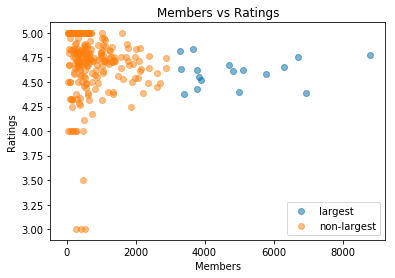

In [58]:
cb_dark_blue = (0/255, 107/255, 164/255)
cb_orange = (255/255, 128/255, 14/255)

# largest tech groups
plt.scatter(largest_tech_groups['members'], 
            largest_tech_groups['rating'],
            color=cb_dark_blue,
            alpha=0.5,
            label='largest')

# non-largest tech groups
plt.scatter(non_largest_groups_with_ratings['members'],
            non_largest_groups_with_ratings['rating'],
            color=cb_orange,
            alpha=0.5,
            label='non-largest')

plt.title('Members vs Ratings')
plt.xlabel('Members')
plt.ylabel('Ratings')
plt.legend()

plt.show()

**Observations**:

- The largest Tech groups **are not rated higher** than the other rated smaller groups
- There are a number of highly rated smaller groups (with ratings close to or at 5.0). This goes along with our earlier findings that ~90% of groups have members in the 100's
- Out of the groups with a rating, a **majority have very high ratings (above 4.0)**

**Groups with no Ratings**

Let's look into groups with no ratings:

In [59]:
groups_with_no_ratings = vancouver_tech_groups[vancouver_tech_groups['rating'] == 0.0]
print(groups_with_no_ratings.shape[0])

143


In [60]:
groups_with_no_ratings['members'].describe()

count     143.000000
mean      111.062937
std       140.850296
min         1.000000
25%        35.000000
50%        60.000000
75%       135.500000
max      1084.000000
Name: members, dtype: float64

In [61]:
groups_with_no_ratings.sort_values('members', ascending=False).head(10)

,id,name,members,rating,join_mode,visibility,who,lat,lon,location
357,28775204,Vancouver AI Tech Talk,1084,0.0,open,public,Members,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"
371,29424450,Devhub Vancouver,646,0.0,open,public,Members,49.279999,-123.120003,"(49.279998779296875, -123.12000274658203)"
131,18221599,Vancouver ACM SIGGRAPH,571,0.0,approval,public,Computer Graphics Professionals,49.279999,-123.110001,"(49.279998779296875, -123.11000061035156)"
223,21464522,Social After Tech,559,0.0,open,public,Members,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"
189,19878077,Futures of Learning,449,0.0,open,public,Learning Practitioners,49.279999,-123.110001,"(49.279998779296875, -123.11000061035156)"
380,29739350,Node&JS Community Hangouts,392,0.0,open,public,Members,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"
297,26682494,Women in Emerging Tech,377,0.0,open,public,Emerging Techies,49.279999,-123.110001,"(49.279998779296875, -123.11000061035156)"
324,27819281,ProductTank Vancouver,344,0.0,open,public,Product People,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"
356,28719901,Design Systems Vancouver,332,0.0,approval,public,Members,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"
326,27851504,Vancity Vue.js,326,0.0,open,public,Developers,49.279999,-123.040001,"(49.279998779296875, -123.04000091552734)"


**Observations**:

- A lot of the groups with no ratings actually have quite a number of members with the largest group having over 1000 members
- I wonder why these groups despite having decent number of members have **0** rating
- One possible explanation could be these groups may have not held an event yet. But I know the _Vancouver AI Tech Talk_ has regular online events where talks are streamed.

---

## Group Events

For the purpose of this initial scoped project, we will look at the group events for the largest tech meetup groups.

We will use the [GetEvents] method.

[GetEvents]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html#meetup.api.meetup.api.Client.GetEvents

In [62]:
# first we need the id of the groups
group_ids = largest_tech_groups['id'].tolist()
ids = ','.join(str(x) for x in group_ids)
ids

'144695,229052,1013148,1526926,1583286,1642334,1751788,1798770,3238812,3946322,4869742,11908342,18381330,18515170,18532714,19162038,19905099'

In [63]:
events_resp = client.GetEvents(group_id=ids, status='past')

22/30 (2 seconds remaining)


In [64]:
events_meta, events_df = parse_response(events_resp)

In [65]:
events_meta

,0
next,https://api.meetup.com/2/events?offset=1&forma...
method,Events
total_count,3283
link,https://api.meetup.com/2/events
count,200
description,"Access Meetup events using a group, member, or..."
lon,
title,Meetup Events v2
url,https://api.meetup.com/2/events?offset=0&forma...
id,


**Observations**

From the response's metadata, we observe that there are **3279** events for our largest tech meetups. As we specified past events, this may have given us all the past events.

Let's limit it to the past 6 months. All time data is represented as **epoch milliseconds**. So we need to represent the date range between now and 6 months ago in this format.

- Today's Date: **Sunday February 24th 2019**
- Six Months Ago: **Friday, August 24th 2018**

In [66]:
def to_millis(dt):
    val = pd.to_datetime(dt)
    print(f"Value:{val}|{val.value}")
    return int(pd.to_datetime(dt).value / 1000000)


#right_now = to_millis(datetime.datetime.now())
right_now = 1550990827123 # represents 2019-02-24 06:47:07 AM PT
six_months_ago = int(right_now -183 * 24 * 60 * 60 * 1000)
print(f"Now: {right_now}\t Six months ago: {six_months_ago}")

Now: 1550990827123	 Six months ago: 1535179627123


The original above cell was run on **Sunday, February 24th 2019 around 06:47:07 AM PT**. In order to keep the analysis below valid, the microsecond value that the `to_millis()` function returned was hard coded in. Otherwise the date would change each time the above cell is run as you can see from the commented out line. I will consider this in future projects and find a better way of keeping the original proper date format.

In [67]:
events_resp = client.GetEvents(group_id=ids, status='past',
                              time=f"{six_months_ago},{right_now}")

events_meta, events_df = parse_response(events_resp)
events_meta

29/30 (10 seconds remaining)


,0
next,https://api.meetup.com/2/events?offset=1&forma...
method,Events
total_count,231
link,https://api.meetup.com/2/events
count,200
description,"Access Meetup events using a group, member, or..."
lon,
title,Meetup Events v2
url,https://api.meetup.com/2/events?offset=0&forma...
id,


Now we get a more reasonable amount of events: **231**

Let's build a function to get all events that interest us:

In [68]:
def get_all_events_as_df(group_ids, event_status, time_range):
    '''returns all events as a dataframe'''
    print(f"Getting {event_status} events for groups '{group_ids}' in time range "
          f" '{time_range}'...")

    events_df_list = []
    page_number = 0
    next_page = None
    
    while next_page != '':
        events_resp = client.GetEvents(
            group_id=group_ids, 
            status=event_status,
            time=time_range,
            offset=page_number
        )
        
        #pprint.pprint(events_resp.meta)
        next_page = events_resp.meta['next']
        _, event_df = parse_response(events_resp)
        
        events_df_list.append(event_df)
        page_number += 1
    
    return pd.concat(events_df_list, ignore_index=True)

In [69]:
%%capture --no-display
event_status = 'past'
time_range = f"{six_months_ago},{right_now}"
events_df = get_all_events_as_df(ids, event_status, time_range)

### Clean Events Data

Now we got all 231 events as originally found. Let's explore our data:

In [70]:
events_df.shape[0]

231

In [71]:
events_df.columns

Index(['created', 'description', 'duration', 'event_url', 'fee', 'group',
       'headcount', 'how_to_find_us', 'id', 'maybe_rsvp_count', 'name',
       'photo_url', 'rating', 'rsvp_limit', 'status', 'time', 'updated',
       'utc_offset', 'venue', 'visibility', 'waitlist_count',
       'yes_rsvp_count'],
      dtype='object')

In [72]:
# transposing our data makes it easier to see values across all the columns
events_df.head(5).transpose()

,0,1,2,3,4
created,1527617768000,1533071518000,1529329339000,1531123424000,1534528323000
description,"<p>Join us for an epic, highly interactive and...",<p>This evening will be about creating geograp...,<p>Looking to tackle big data challenges? Expe...,"<p>""Blockchain is the next step in the evoluti...",<p>&gt;&gt;&gt;&gt; HackerNest Tech Socials (<...
duration,12600000,7200000,5400000,7200000,7200000
event_url,https://www.meetup.com/YVR-Startups/events/251...,https://www.meetup.com/Vancouver-Data-Visualiz...,https://www.meetup.com/BrainStation-Vancouver/...,https://www.meetup.com/Vancouver-Tech-Co-Found...,https://www.meetup.com/HackerNestVAN/events/25...
fee,NaN,NaN,"{'amount': 20, 'currency': 'CAD', 'label': 'Pr...",NaN,NaN
group,"{'join_mode': 'open', 'created': 1462151582000...","{'join_mode': 'open', 'created': 1300139469000...","{'join_mode': 'open', 'created': 1427043156000...","{'join_mode': 'open', 'created': 1263596978000...","{'join_mode': 'open', 'created': 1347316761000..."
headcount,0,0,0,0,0
how_to_find_us,Private dining room and/or ask for Nathan!,NaN,NaN,NaN,NaN
id,bqfbtpyxlbkc,253351123,251882094,gjjzxpyxlbkc,253878418
maybe_rsvp_count,0,0,0,0,0


In [73]:
display_columns_unique_values(events_df)

Column         CREATED: 167
Column     DESCRIPTION: 181
Column        DURATION: 13
Column       EVENT_URL: 231
Column FEE: Type: <class 'float'>
Column GROUP: Type: <class 'dict'>
Column       HEADCOUNT: 1|Unique values: [0]
Column  HOW_TO_FIND_US: 33
Column              ID: 231
Column MAYBE_RSVP_COUNT: 1|Unique values: [0]
Column            NAME: 148
Column       PHOTO_URL: 126
Column RATING: Type: <class 'dict'>
Column      RSVP_LIMIT: 20
Column          STATUS: 1|Unique values: ['past']
Column            TIME: 177
Column         UPDATED: 227
Column      UTC_OFFSET: 2
Column VENUE: Type: <class 'dict'>
Column      VISIBILITY: 1|Unique values: ['public']
Column  WAITLIST_COUNT: 14
Column  YES_RSVP_COUNT: 83


**Filter out unneeded columns**

In [74]:
columns_to_keep = ['group', 'time', 'duration', 'yes_rsvp_count', 'waitlist_count']
past_events_df = events_df.copy()
past_events_df = past_events_df[columns_to_keep]
past_events_df.head(5)

,group,time,duration,yes_rsvp_count,waitlist_count
0,"{'join_mode': 'open', 'created': 1462151582000...",1535418000000,12600000,96,0
1,"{'join_mode': 'open', 'created': 1300139469000...",1535418000000,7200000,35,45
2,"{'join_mode': 'open', 'created': 1427043156000...",1535418000000,5400000,2,0
3,"{'join_mode': 'open', 'created': 1263596978000...",1535418000000,7200000,52,0
4,"{'join_mode': 'open', 'created': 1347316761000...",1535421600000,7200000,65,0


**Clean up Group Column**

In [75]:
# Let's look at the group column which consists of JSON data
past_events_df['group'][0]

{'join_mode': 'open',
 'created': 1462151582000,
 'name': 'YVR Startups',
 'group_lon': -123.13999938964844,
 'id': 19905099,
 'urlname': 'YVR-Startups',
 'group_lat': 49.2599983215332,
 'who': 'Entrepreneurs'}

We only need the **group id**, so let's extract it into its own column and filter out this column:

In [76]:
# Let's extract the group id 
def extract_group_id(group_json):
    '''extracts the group id from group json'''
    return group_json['id']

past_events_df['group_id'] = past_events_df['group'].apply(extract_group_id)

In [77]:
columns_to_keep = ['group_id', 'time', 'duration', 'yes_rsvp_count', 'waitlist_count']
past_events_df = past_events_df[columns_to_keep]
past_events_df.head(5)

,group_id,time,duration,yes_rsvp_count,waitlist_count
0,19905099,1535418000000,12600000,96,0
1,1798770,1535418000000,7200000,35,45
2,18515170,1535418000000,5400000,2,0
3,1583286,1535418000000,7200000,52,0
4,4869742,1535421600000,7200000,65,0


**Change time format**

The _time_ and _duration_ columns are in **epoch milliseconds** format, which is great for the computer but not so great for people.

Let's add human readable columns for these 2:

In [78]:
date_format = '%m/%d/%y %H:%M'
past_events_df['time_human'] = pd.to_datetime(
    past_events_df['time'], unit='ms').dt.strftime(date_format)

past_events_df.head(1)

,group_id,time,duration,yes_rsvp_count,waitlist_count,time_human
0,19905099,1535418000000,12600000,96,0,08/28/18 01:00


In [79]:
def millis_to_hours_and_minutes(ms):
    '''converts milliseconds to hours and minutes'''
    seconds = ms / 1000
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    
    return f"{int(hours)} hours, {int(minutes)} minutes"

past_events_df['duration_human'] = events_df['duration'].apply(millis_to_hours_and_minutes)

past_events_df.head(1)

,group_id,time,duration,yes_rsvp_count,waitlist_count,time_human,duration_human
0,19905099,1535418000000,12600000,96,0,08/28/18 01:00,"3 hours, 30 minutes"


In [80]:
# rename columns
rename_map = {
    'group_id': 'id', #need to change this so we can later merge with the groups df!
    'time': 'time_ms',
    'time_human': 'time',
    'duration': 'duration_ms',
    'duration_human': 'duration'
}
past_events_df = past_events_df.rename(rename_map, axis='columns')

past_events_df.head(1)

,id,time_ms,duration_ms,yes_rsvp_count,waitlist_count,time,duration
0,19905099,1535418000000,12600000,96,0,08/28/18 01:00,"3 hours, 30 minutes"


In [81]:
# re-order columns
new_column_order = ['id', 'time', 'time_ms', 'duration', 'duration_ms',
                   'yes_rsvp_count', 'waitlist_count']

past_events_df = past_events_df[new_column_order]

past_events_df.head(1)

,id,time,time_ms,duration,duration_ms,yes_rsvp_count,waitlist_count
0,19905099,08/28/18 01:00,1535418000000,"3 hours, 30 minutes",12600000,96,0


### Merge Largest Tech Meetups and Events Dataframes

To properly analyze the events, we should match them back up with their respective group.

We will merge the two dataframes (`largest_tech_groups` and `past_events_df`) in a operation which is similar to a _left join_ in SQL.

Left Join is picked as we want to retain all rows from our past events dataframe, while getting only the rows from our groups dataframe. Although in this case, as the events were derived from the group and assuming each group hosted at least one event in the past 6 months, we should end up retaining all events and all groups data.

We will filter out unnecessary columns and sort the ouput by **group name** ascending and then **time** descending.

In [82]:
print(f"Largest Tech Groups Columns:\n{largest_tech_groups.columns}")
print(f"\nPast Events Columns:\n{past_events_df.columns}")

Largest Tech Groups Columns:
Index(['id', 'name', 'members', 'rating', 'join_mode', 'visibility', 'who',
       'lat', 'lon', 'location'],
      dtype='object')

Past Events Columns:
Index(['id', 'time', 'time_ms', 'duration', 'duration_ms', 'yes_rsvp_count',
       'waitlist_count'],
      dtype='object')


In [83]:
merged_df = pd.merge(
    past_events_df,
    largest_tech_groups[['id', 'name']],
    on='id',
    how='left'
)

merged_df.head(3)

,id,time,time_ms,duration,duration_ms,yes_rsvp_count,waitlist_count,name
0,19905099,08/28/18 01:00,1535418000000,"3 hours, 30 minutes",12600000,96,0,YVR Startups
1,1798770,08/28/18 01:00,1535418000000,"2 hours, 0 minutes",7200000,35,45,Vancouver Data Visualization
2,18515170,08/28/18 01:00,1535418000000,"1 hours, 30 minutes",5400000,2,0,BrainStation Vancouver


In [84]:
columns_to_keep = ['id', 'name', 'time', 'time_ms', 
                   'duration', 'yes_rsvp_count', 'waitlist_count']

final_df = merged_df[columns_to_keep]

# Sort output by name and time
final_df = final_df.sort_values(by=['name', 'time_ms'], ascending=[True, False])
final_df.head(5)

,id,name,time,time_ms,duration,yes_rsvp_count,waitlist_count
195,1751788,Agile Vancouver,01/23/19 02:00,1548208800000,"3 hours, 0 minutes",100,39
123,1751788,Agile Vancouver,11/21/18 02:00,1542765600000,"2 hours, 0 minutes",120,14
70,1751788,Agile Vancouver,10/17/18 01:00,1539738000000,"2 hours, 0 minutes",75,0
34,1751788,Agile Vancouver,09/19/18 01:00,1537318800000,"2 hours, 0 minutes",66,0
109,3238812,Bitcoin Vancouver,11/11/18 01:30,1541899800000,"4 hours, 30 minutes",14,0


In [85]:
final_df.shape

(231, 7)

### Explore Events Data

Now that we have gotten our data into a shape that interests us, time for the fun part :) exploring.

First, let's visualize the Yes RSVP trend lines over time via Seaborn's [lmplot] function:

[lmplot]: https://seaborn.pydata.org/generated/seaborn.lmplot.html

Text(0.5, 1.0, "Yes RSVP's over Time")

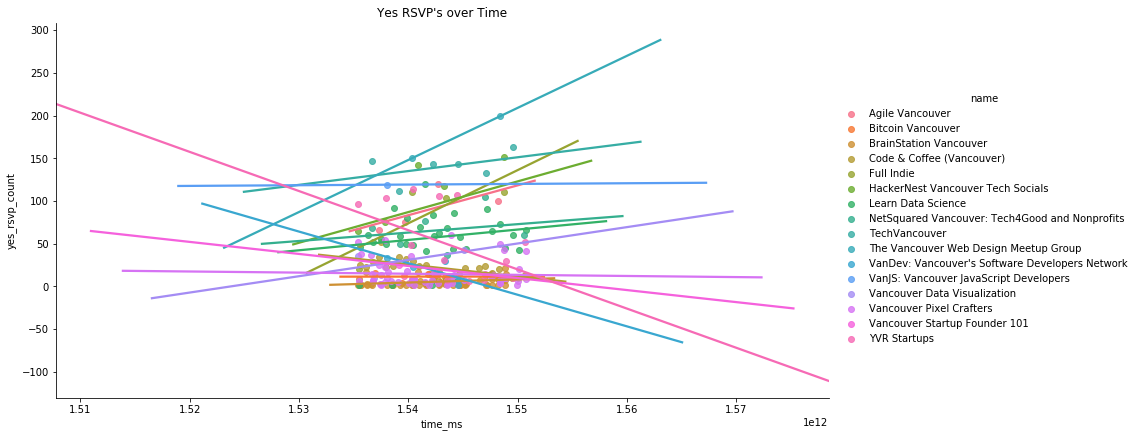

In [86]:
g = sns.lmplot(x="time_ms", y="yes_rsvp_count", 
          data=final_df, hue="name", 
          height=6, aspect=2, 
          order=1, ci=None)

plt.title("Yes RSVP's over Time")

**Observations**:

- There are several groups with upwards trending lines
- There are a few groups with downward trending lines

One group in particular has the largest downward trending line. I think it's the _YVR Startups_ group. Let's confirm:

In [87]:
downward_group = final_df[final_df['name'] == 'YVR Startups']
downward_group

,id,name,time,time_ms,duration,yes_rsvp_count,waitlist_count
227,19905099,YVR Startups,02/21/19 03:00,1550718000000,"2 hours, 0 minutes",52,0
217,19905099,YVR Startups,02/08/19 02:00,1549591200000,"2 hours, 30 minutes",10,0
213,19905099,YVR Startups,02/01/19 01:30,1548984600000,"3 hours, 30 minutes",30,0
176,19905099,YVR Startups,01/08/19 02:00,1546912800000,"3 hours, 0 minutes",8,0
173,19905099,YVR Startups,12/23/18 01:00,1545526800000,"5 hours, 0 minutes",6,0
156,19905099,YVR Startups,12/11/18 01:30,1544491800000,"4 hours, 30 minutes",107,0
141,19905099,YVR Startups,11/29/18 21:00,1543525200000,"29 hours, 30 minutes",8,0
132,19905099,YVR Startups,11/27/18 03:00,1543287600000,"2 hours, 0 minutes",31,0
129,19905099,YVR Startups,11/22/18 02:00,1542852000000,"3 hours, 0 minutes",106,0
121,19905099,YVR Startups,11/20/18 02:00,1542679200000,"3 hours, 0 minutes",15,0


This group has events with over 100 attendees and others with only a handful but there isn't necessarily a downward spiral. The extreme slumps (less than 10 attendees) may be attributed to holidays - 2 events on December 23rd and January 8th had less than 10 attendees. Another event on November 29th also had only 8 attendees, though not sure what could have caused that.

Let's try removing this group and see the plot again:

In [88]:
without_yvr_startups = final_df[final_df['name'] != 'YVR Startups']

In [89]:
without_yvr_startups.shape

(216, 7)

In [90]:
without_yvr_startups['name'].unique()

array(['Agile Vancouver', 'Bitcoin Vancouver', 'BrainStation Vancouver',
       'Code & Coffee (Vancouver)', 'Full Indie',
       'HackerNest Vancouver Tech Socials', 'Learn Data Science',
       'NetSquared Vancouver: Tech4Good and Nonprofits', 'TechVancouver',
       'The Vancouver Web Design Meetup Group',
       "VanDev: Vancouver's Software Developers Network",
       'VanJS: Vancouver JavaScript Developers',
       'Vancouver Data Visualization', 'Vancouver Pixel Crafters',
       'Vancouver Startup Founder 101'], dtype=object)

Text(0.5, 1.0, "Yes RSVP's over Time")

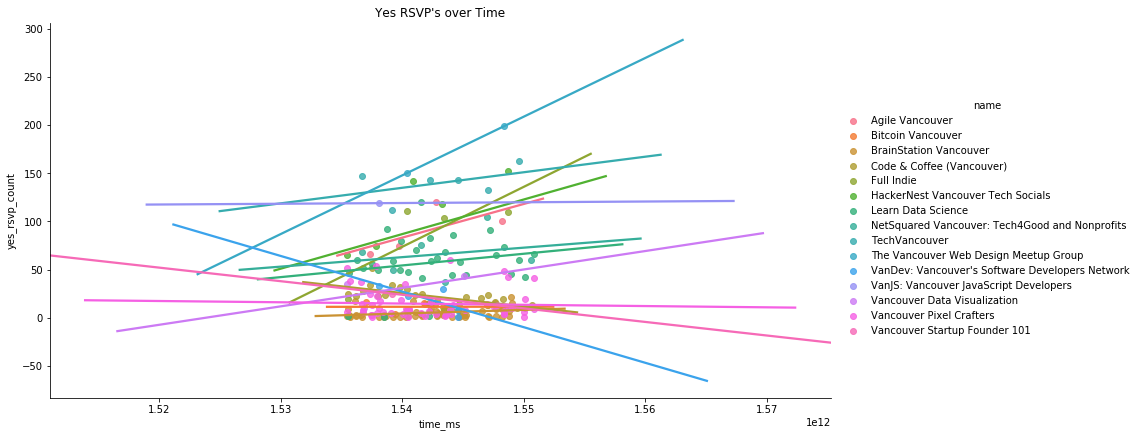

In [91]:
g = sns.lmplot(x="time_ms", y="yes_rsvp_count", 
          data=without_yvr_startups, hue="name", 
          height=6, aspect=2, 
          order=1, ci=None)

plt.title("Yes RSVP's over Time")

**Observations**:

We are able to confirm the largest downward trending group was the The _YVR Startups_ group. It was quite an outlier.

We get a slightly closer view of the remaining plots. But it isn't quite easy to figure out which groups to pick.

Let's look at average RSVPs and frequency of events:

**Average RSVPs**

In [92]:
rsvp_df = final_df.groupby(['name'], as_index=False).mean()

rsvp_df = rsvp_df.sort_values(by=['yes_rsvp_count', 'name'], ascending=[True, True])
rsvp_df

,name,id,time_ms,yes_rsvp_count,waitlist_count
2,BrainStation Vancouver,18515170.0,1.542418e+12,5.360656,0.000000
1,Bitcoin Vancouver,3238812.0,1.540088e+12,11.400000,0.000000
13,Vancouver Pixel Crafters,1583286.0,1.542226e+12,14.481481,0.000000
10,VanDev: Vancouver's Software Developers Network,144695.0,1.542207e+12,19.000000,2.600000
14,Vancouver Startup Founder 101,18381330.0,1.543088e+12,19.500000,0.000000
3,Code & Coffee (Vancouver),11908342.0,1.542799e+12,21.730769,0.076923
12,Vancouver Data Visualization,1798770.0,1.539124e+12,29.333333,15.000000
15,YVR Startups,19905099.0,1.543489e+12,49.733333,0.000000
6,Learn Data Science,18532714.0,1.542407e+12,57.258065,4.225806
7,NetSquared Vancouver: Tech4Good and Nonprofits,1013148.0,1.543106e+12,66.000000,0.166667


**Observations**:

There are 7 groups that get less than 30 YES RSVPs on average. As these groups have members of over 3000, 30 RSVPs represents only **1%** of all members of these groups.

Out of these 3 had a non 0 average for their waitlist count:

- VanDev: Vancouver's Software Developers Network
- Code & Coffee (Vancouver)
- Vancouver Data Visualization

Which leads to another question:

- How can a group have on average low RSVPs yet have people on the waitlist?

Let's focus on YES RSVPs for now and drop these groups.

In [93]:
groups_to_drop = [
    'BrainStation Vancouver', 'Bitcoin Vancouver',
    'Code & Coffee (Vancouver)', 'Vancouver Startup Founder 101',
    "VanDev: Vancouver's Software Developers Network",
    'Vancouver Data Visualization', 'Vancouver Pixel Crafters',
]

largest_groups_events = final_df.copy()
largest_groups_events = largest_groups_events[~largest_groups_events['name'].isin(
    groups_to_drop)]

print(largest_groups_events.shape)
print(f"\nRemaining Groups:\n{largest_groups_events['name'].unique()}")

(75, 7)

Remaining Groups:
['Agile Vancouver' 'Full Indie' 'HackerNest Vancouver Tech Socials'
 'Learn Data Science' 'NetSquared Vancouver: Tech4Good and Nonprofits'
 'TechVancouver' 'The Vancouver Web Design Meetup Group'
 'VanJS: Vancouver JavaScript Developers' 'YVR Startups']


**Frequency of Events**

In [94]:
event_count_df = largest_groups_events.groupby('name', as_index=False).count()

event_count_df = event_count_df.sort_values(by='name', ascending=True)
event_count_df

,name,id,time,time_ms,duration,yes_rsvp_count,waitlist_count
0,Agile Vancouver,4,4,4,4,4,4
1,Full Indie,4,4,4,4,4,4
2,HackerNest Vancouver Tech Socials,6,6,6,6,6,6
3,Learn Data Science,31,31,31,31,31,31
4,NetSquared Vancouver: Tech4Good and Nonprofits,6,6,6,6,6,6
5,TechVancouver,6,6,6,6,6,6
6,The Vancouver Web Design Meetup Group,2,2,2,2,2,2
7,VanJS: Vancouver JavaScript Developers,1,1,1,1,1,1
8,YVR Startups,15,15,15,15,15,15


**Observation**:

- With the exception of _Learn Data Science_ and _YVR Startups_, every other group met less than 10 times in the past 6 months
- A couple of meetups have only met once or twice:
    - _VanJS: Vancouver JavaScript Developers_ met only once
    - _Vancouver Web Design Meetup Group_ met twice

**Focus on Infrequently meeting groups**

Let's filter out _Learn Data Science_ and _YVR Startups_ and see when was the last time the other meetups met.

In [95]:
groups_to_drop = ['Learn Data Science', 'YVR Startups']

infrequent_groups = largest_groups_events[~largest_groups_events['name'].isin(
    groups_to_drop)]

print(infrequent_groups.shape)
print(f"\nRemaining Groups:\n{infrequent_groups['name'].unique()}")

(29, 7)

Remaining Groups:
['Agile Vancouver' 'Full Indie' 'HackerNest Vancouver Tech Socials'
 'NetSquared Vancouver: Tech4Good and Nonprofits' 'TechVancouver'
 'The Vancouver Web Design Meetup Group'
 'VanJS: Vancouver JavaScript Developers']


In [96]:
infrequent_groups.sort_values(by=['name', 'time_ms'], ascending=[True, True])

,id,name,time,time_ms,duration,yes_rsvp_count,waitlist_count
34,1751788,Agile Vancouver,09/19/18 01:00,1537318800000,"2 hours, 0 minutes",66,0
70,1751788,Agile Vancouver,10/17/18 01:00,1539738000000,"2 hours, 0 minutes",75,0
123,1751788,Agile Vancouver,11/21/18 02:00,1542765600000,"2 hours, 0 minutes",120,14
195,1751788,Agile Vancouver,01/23/19 02:00,1548208800000,"3 hours, 0 minutes",100,39
8,1642334,Full Indie,08/29/18 01:00,1535504400000,"3 hours, 0 minutes",20,14
83,1642334,Full Indie,10/24/18 02:00,1540346400000,"2 hours, 0 minutes",111,0
140,1642334,Full Indie,11/29/18 03:00,1543460400000,"2 hours, 0 minutes",104,0
206,1642334,Full Indie,01/29/19 03:00,1548730800000,"2 hours, 0 minutes",110,0
4,4869742,HackerNest Vancouver Tech Socials,08/28/18 02:00,1535421600000,"2 hours, 0 minutes",65,0
43,4869742,HackerNest Vancouver Tech Socials,09/25/18 02:00,1537840800000,"2 hours, 0 minutes",75,0


**Observations**:

1. 2 Meetup groups don't meet frequently enough but have large attendance when they do (over 150 people):
    - _VanJS: Vancouver JavaScript Developers_ had 1 event on September 28th 2018
    - _The Vancouver Web Design Meetup Group_ had 1 event on October 2018 and 1 on January 2019.
2. The other Meetup groups meet once a month with a few groups skipping 1-2 months. The month of December are the holidays and people are busy with end of year activities both at work and in their personal lives, so it is understandable if meetups didn't host any events then.
3. The other Meetup groups are also in general increasing or maintaining their attendance over time with a few exceptions/outliers as mentioned in point 2 above.

We should drop the 2 infrequently meeting groups.

**Focus on Frequently meeting groups**

Let's also look at the frequency of events for the two meetups which meet the most often:
- Learn Data Science
- YVR Startups

In [97]:
groups_to_keep = ['Learn Data Science', 'YVR Startups']

frequent_groups = largest_groups_events[largest_groups_events['name'].isin(
    groups_to_drop)]

print(frequent_groups.shape)
print(f"\nRemaining Groups:\n{frequent_groups['name'].unique()}")

(46, 7)

Remaining Groups:
['Learn Data Science' 'YVR Startups']


In [98]:
frequent_groups.sort_values(by=['name', 'time_ms'], ascending=[True, True])

,id,name,time,time_ms,duration,yes_rsvp_count,waitlist_count
7,18532714,Learn Data Science,08/29/18 01:00,1535504400000,"2 hours, 30 minutes",2,40
13,18532714,Learn Data Science,08/30/18 01:00,1535590800000,"3 hours, 0 minutes",46,0
20,18532714,Learn Data Science,09/07/18 01:00,1536282000000,"2 hours, 0 minutes",60,0
29,18532714,Learn Data Science,09/13/18 01:00,1536800400000,"3 hours, 0 minutes",52,0
38,18532714,Learn Data Science,09/21/18 01:00,1537491600000,"2 hours, 0 minutes",56,0
48,18532714,Learn Data Science,09/27/18 01:00,1538010000000,"3 hours, 0 minutes",50,0
56,18532714,Learn Data Science,10/03/18 00:00,1538524800000,"3 hours, 0 minutes",1,0
60,18532714,Learn Data Science,10/05/18 01:00,1538701200000,"2 hours, 0 minutes",92,0
67,18532714,Learn Data Science,10/11/18 01:00,1539219600000,"3 hours, 0 minutes",59,0
73,18532714,Learn Data Science,10/18/18 00:00,1539820800000,"2 hours, 0 minutes",50,50


**Observations**:

_YVR Startups_

Similar to its YES RSVPs, _YVR Startups_ isn't consistent in the frequency of their events. Sometimes they meet once a month such as in August, September and January. Other months, they meet multiple times a month.


_Learn Data Science_

_Learn Data Science_ meets at least once a week and most times multiple times a week. It has met **31** times in the past 6 months (~26 weeks). Pretty impressive!

In terms of YES RSVPs, it fluctuates and has a few extreme cases such as 120 RSVPS on November 11th 2018 and 2 on November 14th 2018. On average, they had YES RSVPS of 57 people.

In [99]:
groups_to_drop = ['VanJS: Vancouver JavaScript Developers', 
                  'The Vancouver Web Design Meetup Group']

largest_groups_events = largest_groups_events[~largest_groups_events['name'].isin(
    groups_to_drop)]

print(largest_groups_events.shape)
print(f"\nRemaining Groups:\n{largest_groups_events['name'].unique()}")

(72, 7)

Remaining Groups:
['Agile Vancouver' 'Full Indie' 'HackerNest Vancouver Tech Socials'
 'Learn Data Science' 'NetSquared Vancouver: Tech4Good and Nonprofits'
 'TechVancouver' 'YVR Startups']


**Back to our plot**

Let's plot our earlier plot of YES RSVPs over Time for the Meetup groups we decided to keep:

Text(0.5, 1.0, "Yes RSVP's over Time")

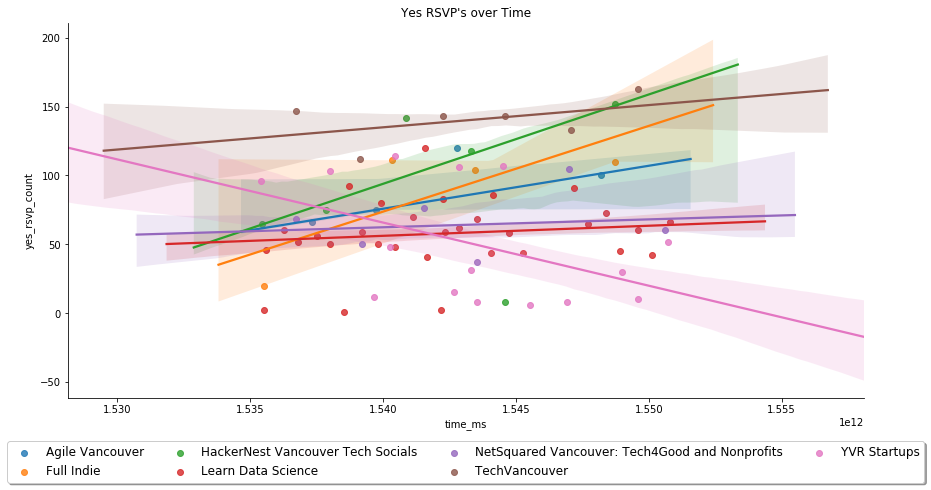

In [126]:
%%capture --no-display
g = sns.lmplot(
    x="time_ms", y="yes_rsvp_count", 
    data=largest_groups_events, hue="name", 
    height=6, aspect=2, order=1,
    ci=68,
    robust=True, legend=False)


#plt.setp(g._legend.get_texts(), fontsize='13') # for legend text
#plt.setp(g._legend.get_title(), fontsize='14') # for legend title

plt.legend(loc='upper center',
           bbox_to_anchor=(0.5, -0.1),
           prop={'size': 12},
           fancybox=True,
           shadow=True,
           ncol=4
          )
plt.title("Yes RSVP's over Time")

**Observations**:

With the exception of _YVR Startups_ with its inconsistent attendee count, all other Meetups are generally increasing or maintaining their attendance.

Also more generally, some Meetup groups attract a lot of RSVPs but meet very infrequently - once every few months.

---

# Discovery

Let's list our discoveries for Tech Meetup Groups in Vancouver, BC:

_Groups_

- The average number of members is **680**
- Almost **80%** have less than 900 members
- The largest groups tended to be centered around Downtown and the surrounding areas while the smallest groups were more spread across the city.
- The smallest groups had a rating of **0**
- The largest groups catered to more specific audiences than the smallest groups.
- The largest groups were not rated higher than smaller groups
- Most of the rated groups were rated **higher than 4.0**
- 10 groups had 100's of members yet a rating of **0**

Focusing exclusively on events for the largest Tech Meetups, we discovered:

_Events_

- The following Meetups meet frequently (once to multiple times a month) and are either maintaining or increasing their attendance:
    - Agile Vancouver
    - Full Indie
    - HackerNest Vancouver Tech Socials
    - NetSquared Vancouver: Tech4Good and Nonprofits
    - TechVancouver
    - Learn Data Science

# Recommendations

**4th Place**

If you are into Web Development and Design and don't mind joining a group that meets once every few months, but that has a large number of attendees, you should join the following groups:

- The Vancouver Web Design Meetup Group
- VanJS: Vancouver JavaScript Developers


**3rd Place**

If you want to join a Tech Meetup Group that meets at least once a month and has a lots of attendees, you should join the following groups:

- Agile Vancouver
- Full Indie
- HackerNest Vancouver Tech Socials
- NetSquared Vancouver: Tech4Good and Nonprofits
- TechVancouver


**2nd Place**

If you want to join an Entrepreneurship and Startups focused Meetup Group that meets several times a month and has a decent but sometimes inconsistent attendance, you should join the following group:

- YVR Startups


**1st Place**

If you are into Data Science and want to join a Meetup Group that meets several times a week and has lots of attendees, you should join the following group:

- Learn Data Science

# Conclusion

We set out to explore Tech Meetups in Vancouver, BC and made some interesting discoveries and concluded with a few recommendations for folks looking to join Meetup groups.

To get here, we:

1. Worked with the Python Meetup API client
2. Built helper functions to:
    - Parse the API responses into **meta** and **results** dataframes
    - Loop through multiple API calls and concatenate records into a single dataframe
3. Explored the structure of our data so to filter and clean it
4. Created several plots (DataFrame, Seaborn) to
    - See the distribution of number of members
    - See group's ratings
    - Find where the largest and smallest groups were located
    - See how event YES RSVP's changed over time
5. Used [pandas.DataFrame.merge] to join the **events** and **groups** dataframes to find how frequently the largest groups hosted events and their attendance


[Python Meetup API client]: https://meetup-api.readthedocs.io/en/latest/meetup_api.html#api-client-details
[pandas.DataFrame.merge]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html

# Resources

- [Find Lat Long Website]
- [Stack Overflow: How to put the legend out of Plot]

[Find Lat Long Website]: http://www.corebroadband.ca/findlatlong/
[Stack Overflow: How to put the legend out of Plot]: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot